# 1. Importing and Visualization of CIFAR-10 Dataset

In [11]:
import numpy as np

# function to import CIFAR-10 data set
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
data_batch_1 = unpickle("./data/data_batch_1")
data_batch_2 = unpickle("./data/data_batch_2")
data_batch_3 = unpickle("./data/data_batch_3")
data_batch_4 = unpickle("./data/data_batch_4")
data_batch_5 = unpickle("./data/data_batch_5")
test_batch = unpickle("./data/test_batch")

What is the data structure of e.g. data_batch_1 ?

In [2]:
type(data_batch_1)

dict

What are the keys of e.g. data_batch_1 ?

In [3]:
data_batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

What is the data structure of data_batch_1[b'data'] ?

In [4]:
type(data_batch_1[b'data'])

numpy.ndarray

What is the data structure of data_batch_1[b'labels'] ?

In [5]:
type(data_batch_1[b'labels'])

list

What is the shape of data_batch_1[b'data'] ?

In [6]:
data_batch_1[b'data'].shape

(10000, 3072)

What is the size of data_batch_1[b'labels'] ?


In [7]:
len(data_batch_1[b'labels'])

10000

What are the first 10 elements of data_batch_1[b'labels'] ?

In [8]:
data_batch_1[b'labels'][:10]

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]

What is the data type of data_batch_1[b'data'] ?

In [9]:
data_batch_1[b'data'].dtype

dtype('uint8')

Let us concatenate the batch training data

In [12]:
X_train=np.concatenate([data_batch_1[b'data'], 
                         data_batch_2[b'data'], 
                         data_batch_3[b'data'], 
                         data_batch_4[b'data'], 
                         data_batch_5[b'data']], 
                         axis = 0)

Let us concatenate the training labels

In [13]:
y_train=np.concatenate([data_batch_1[b'labels'] , 
                data_batch_2[b'labels'],
                data_batch_3[b'labels'],
                data_batch_4[b'labels'],
                data_batch_5[b'labels']], 
                axis = 0)

Let us define the test data as X_test

In [14]:
X_test = test_batch[b'data']
X_test.shape

(10000, 3072)

Let us cast the test labels as ndarray

In [15]:
y_test=np.array(test_batch[b'labels']) 
y_test.shape

(10000,)

What is the shape of X_train ?

In [16]:
X_train.shape

(50000, 3072)

What is the shape of Y_train ?

In [17]:
y_train.shape

(50000,)

Let us visualize an image. 

By default, NumPy arrays are created in row major order. 
Spatially this means, that if we have a two-dimensional 
array of data, the items in each row of the array are stored 
in adjacent memory locations. In the case of a three-dimensional 
array of data, the items along `axis=2` are stored in adjacent order. 

Since the first $32$ entries of the array $X\_train[0]$ are the 
red channel values of the first row of the image, etc., we need to 
pass the tuple $(3,32,32)$ to reshape. 

By default, NumPy arrays are created in row major order, that is, when 
reshaping the array, higher order dimensions are traversed first 
(e.g. `axis=2`  before advancing on `axis=1`.)


`plt.imshow` needs for each inner list the values representing 
a pixel. Here, with an RGB image, there are 3 values. We thus 
need to transpose the array : the RGB values need to be located 
along `axis=2`. 

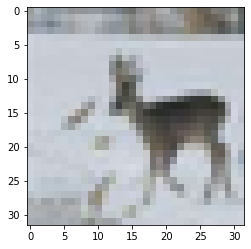

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(X_train[20].reshape((3,32,32)).transpose((1,2,0)).astype('uint8'))
plt.show()

We visualize some examples from the dataset.
We show a few examples of training images from each class.

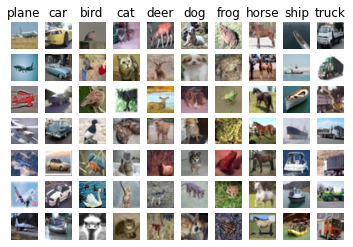

In [20]:
%matplotlib inline
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7



for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((3,32,32)).transpose((1,2,0)).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# 2. K-Nearest-Neighbour Classifier

 We subsample the data for more efficient code execution in this exercise.

In [21]:
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

We define Class KNearestNeighbor.

In [22]:
class KNearestNeighbor():
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X.astype('float')
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each 
    training point in self.X_train using a nested loop over both 
    the training data and the test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where 
      dists[i, j] is the Euclidean distance between the ith test 
      point and the jth training point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    X = X.astype('float')
    for i in range(num_test):
      for j in range(num_train):
          dists[i, j] = np.sqrt(np.sum(np.square(self.X_train[j,:] - X[i,:])))
        
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    X = X.astype('float')
    for i in range(num_test):
      dists[i, :] = np.sqrt(np.sum(np.square(self.X_train - X[i,:]), axis = 1))
      
     
    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    X=X.astype('float')
    
    # Most "elegant" solution leads however to memory issues
    # dists = np.sqrt(np.square((self.X_train[:, np.newaxis, :] - X)).sum(axis=2)).T
    # split (p-q)^2 to p^2 + q^2 - 2pq
    dists = np.sqrt((X**2).sum(axis=1)[:, np.newaxis] + (self.X_train**2).sum(axis=1) - 2 * X.dot(self.X_train.T))
                     
    
    
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test, dtype='float64')
    for i in range(num_test):
        # A list of length k storing the labels of the k nearest neighbors to
        # the ith test point.
        closest_y = []
        # get the k indices with smallest distances
        min_indices = np.argsort(dists[i,:])[:k] 
        closest_y = np.bincount(self.y_train[min_indices])
        # predict the label of the nearest example
        y_pred[i] = np.argmax(closest_y)  

    return y_pred

Create an instance nn from the class KNearestNeighbor

In [23]:
classifier = KNearestNeighbor()

We call the method `train` of the `KNearestNeighbor` class.

In [24]:
classifier.train(X_train, y_train)

We test our implementation with two_loops

In [25]:
dists = classifier.compute_distances_two_loops(X_test)
dists.shape  

(500, 5000)

We can visualize the distance matrix: each row is a single test example and its distances to training examples

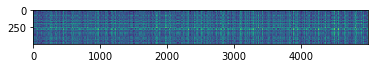

In [26]:
plt.imshow(dists, interpolation='none')
plt.show()

Let us now predict labels and run the code below: We use $k = 1$ (which is Nearest Neighbor).

In [27]:
y_test_pred = classifier.predict_labels(dists, k=1)

We compute and print the fraction of correctly predicted examples.

In [28]:
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))


Got 137 / 500 correct => accuracy: 0.274000


 Let us now predict labels and run the code below: We use k = 10

In [29]:
y_test_pred = classifier.predict_labels(dists, k=10)

We compute and print the fraction of correctly predicted examples.

In [30]:
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test_pred)
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


## Confusion Matrix

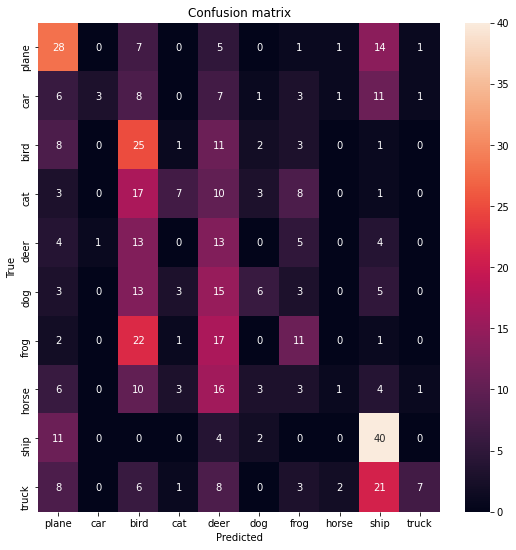

In [31]:
# utility function for plotting confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confmat(y_true, y_pred):
    """
    Plot the confusion matrix and save to user_files dir
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(111)
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='.0f')
    plt.title('Confusion matrix')
    ax.set_xticklabels( classes)
    ax.set_yticklabels( classes)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    
plot_confmat(y_test, y_test_pred)    

## Algebra and Performance of Distance Matrix Computation


To ensure that our vectorized implementation is correct, we make sure that it
agrees with the naive implementation. There are many ways to decide whether
two matrices are similar; one of the simplest is the Frobenius norm. In case
you haven't seen it before, the Frobenius norm of two matrices is the square
root of the squared sum of differences of all elements; in other words, reshape
the matrices into vectors and compute the Euclidean distance between them.

In [32]:
dists_two  = classifier.compute_distances_two_loops(X_test)
dists_one  = classifier.compute_distances_one_loop(X_test)
dists_zero = classifier.compute_distances_no_loops(X_test)


difference_two_2_one = np.linalg.norm(dists_two - dists_one, ord='fro')
print('Difference was: %f' % (difference_two_2_one, ))
if difference_two_2_one < 0.001:
  print('Good! The distance matrices are the same')
else:
  print('Uh-oh! The distance matrices are different')

difference_one_2_zero = np.linalg.norm(dists_one - dists_zero, ord='fro')
print('Difference was: %f' % (difference_one_2_zero, ))
if difference_one_2_zero < 0.001:
  print('Good! The distance matrices are the same')
else:
  print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same
Difference was: 0.000000
Good! The distance matrices are the same


Let's compare how fast the implementations are

In [ ]:
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)


#  3. k-fold cross validation


In [ ]:
num_folds = 5

k_choices = [1, 3, 5, 7, 9, 10, 12, 15, 18, 20, 50, 100]

X_train_folds = []
y_train_folds = []

Split up the training data into folds. After splitting, `X_train_folds` and    
`y_train_folds` should each be lists of length `num_folds`, where                
`y_train_folds[i]` is the label vector for the points in `X_train_folds[i]`.     

In [ ]:
num_train = X_train.shape[0]
fold_size = np.ceil(num_train/num_folds).astype('int')

In the case of `num_train = 5000` and 5 folds, we obtain 
`X_train_folds = np.split(X_train, [1000, 2000, 3000, 4000])`
`y_train_folds = np.split(y_train, [1000, 2000, 3000, 4000])`

In [ ]:
X_train_folds = np.split(X_train, [(i + 1)*fold_size for i in np.arange(num_folds)])
y_train_folds = np.split(y_train, [(i + 1)*fold_size for i in np.arange(num_folds)])


In [ ]:
X_train_folds[1].shape

A dictionary holding the accuracies for different values of $k$ that we find
when running cross-validation. After running cross-validation,
`k_to_accuracies[k]` should be a list of length `num_folds` giving the different
accuracy values that we found when using that value of $k$.

In [ ]:
k_to_accuracies = {}

We perform $k$-fold cross validation to find the best value of $k$. For each     
possible value of $k$, run the $k$-nearest-neighbor algorithm `num_folds` times,   
where in each case you use all but one of the folds as training data and the 
last fold as a validation set. Store the accuracies for all fold and all     
values of k in the `k_to_accuracies` dictionary.  

In [ ]:
for k in k_choices:
  
  k_to_accuracies[k] = []
  classifier = KNearestNeighbor()
  for i in range(num_folds):
      X_cv_training = np.concatenate([x for k, x in enumerate(X_train_folds) if k!=i], axis=0)
      y_cv_training = np.concatenate([x for k, x in enumerate(y_train_folds) if k!=i], axis=0)
      classifier.train(X_cv_training, y_cv_training)
      dists = classifier.compute_distances_no_loops(X_train_folds[i])
      y_test_pred = classifier.predict_labels(dists, k=k)
      k_to_accuracies[k].append(np.mean(y_train_folds[i] == y_test_pred))
  


We print out the computed accuracies.

In [ ]:
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


We plot the raw observations.

In [ ]:
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

 We plot the trend line with error bars that correspond to standard deviation.

In [ ]:
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

 # K-Nearest Neighbor with L1 distance

In [ ]:
class KNearestNeighbor_L1(KNearestNeighbor):
  """ a kNN classifier with L1 distance """

  def __init__(self):
    super().__init__()
    

  def compute_distances_one_loop(self, X):
    """
    We overwrite the compute_distance_one_loop method of the parent class 
    KNearestNeighbor. 
    Compute the distance between each test point in X and each training point
    in self.X_train using one loop and the L1 distance measure.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    X = X.astype('float')
    for i in range(num_test):
      dists[i, :] = (np.sum(np.abs(self.X_train - X[i,:]), axis = 1))
      
     
    return dists
       

We create an instance nn form the class `KNearestNeighbor_L1`

In [87]:
classifier = KNearestNeighbor_L1()

Call the method train of the `KNearestNeighbor` class

In [88]:
classifier.train(X_train, y_train)

We test our implementation with one loop.

In [89]:
dists = classifier.compute_distances_one_loop(X_test)
dists.shape  

(500, 5000)

 Let us now predict labels and run the code below: We use $k = 10$

In [90]:
y_test_pred = classifier.predict_labels(dists, k=10)

We compute and print the fraction of correctly predicted examples.

In [91]:
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test_pred)
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)) 

Got 139 / 500 correct => accuracy: 0.278000


The confusion matrix looks as follows:

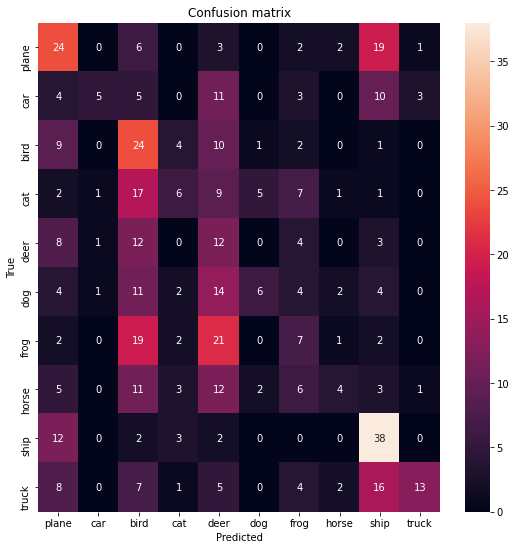

In [92]:
# utility function for plotting confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confmat(y_true, y_pred):
    """
    Plot the confusion matrix and save to user_files dir
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(111)
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='.0f')
    plt.title('Confusion matrix')
    ax.set_xticklabels( classes)
    ax.set_yticklabels( classes)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    
plot_confmat(y_test, y_test_pred)    

# k-fold cross validation

In [93]:
num_folds = 5

k_choices = [1, 3, 5, 7, 9, 10, 12, 15, 18, 20, 50, 100]

X_train_folds = []
y_train_folds = []

We Split up the training data into folds. After splitting, `X_train_folds` and    
`y_train_folds` should each be lists of length `num_folds`, where                
`y_train_folds[i]` is the label vector for the points in `X_train_folds[i]`  

In [94]:
num_train = X_train.shape[0]
fold_size = np.ceil(num_train/num_folds).astype('int')

 In the case of `num_train = 5000` and 5 folds, we obtain 
`X_train_folds = np.split(X_train, [1000, 2000, 3000, 4000])`
`y_train_folds = np.split(y_train, [1000, 2000, 3000, 4000])`

In [95]:
X_train_folds = np.split(X_train, [(i + 1)*fold_size for i in np.arange(num_folds)])
y_train_folds = np.split(y_train, [(i + 1)*fold_size for i in np.arange(num_folds)])


A dictionary holding the accuracies for different values of $k$ that we find
when running cross-validation. After running cross-validation,
`k_to_accuracies[k]` should be a list of length num_folds giving the different
accuracy values that we found when using that value of $k$.

In [96]:
k_to_accuracies = {}

We perform $k$-fold cross validation to find the best value of $k$. For each     
possible value of $k$, run the $k$-nearest-neighbor algorithm `num_folds` times,   
where in each case you use all but one of the folds as training data and the 
last fold as a validation set. Store the accuracies for all fold and all     
values of $k$ in the `k_to_accuracies` dictionary.       

In [102]:
for k in k_choices:
  
  k_to_accuracies[k] = []
  classifier = KNearestNeighbor_L1()
  for i in range(num_folds):
      X_cv_training = np.concatenate([x for k, x in enumerate(X_train_folds) if k!=i], axis=0)
      y_cv_training = np.concatenate([x for k, x in enumerate(y_train_folds) if k!=i], axis=0)
      classifier.train(X_cv_training, y_cv_training)
      dists = classifier.compute_distances_one_loop(X_train_folds[i])
      y_test_pred = classifier.predict_labels(dists, k=k)
      k_to_accuracies[k].append(np.mean(y_train_folds[i] == y_test_pred))
  


We print out the computed accuracies.

In [103]:
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))



k = 1, accuracy = 0.291000
k = 1, accuracy = 0.313000
k = 1, accuracy = 0.294000
k = 1, accuracy = 0.275000
k = 1, accuracy = 0.308000
k = 3, accuracy = 0.269000
k = 3, accuracy = 0.299000
k = 3, accuracy = 0.290000
k = 3, accuracy = 0.278000
k = 3, accuracy = 0.296000
k = 5, accuracy = 0.275000
k = 5, accuracy = 0.311000
k = 5, accuracy = 0.301000
k = 5, accuracy = 0.314000
k = 5, accuracy = 0.309000
k = 7, accuracy = 0.280000
k = 7, accuracy = 0.329000
k = 7, accuracy = 0.313000
k = 7, accuracy = 0.320000
k = 7, accuracy = 0.313000
k = 9, accuracy = 0.291000
k = 9, accuracy = 0.314000
k = 9, accuracy = 0.310000
k = 9, accuracy = 0.322000
k = 9, accuracy = 0.315000
k = 10, accuracy = 0.289000
k = 10, accuracy = 0.312000
k = 10, accuracy = 0.320000
k = 10, accuracy = 0.323000
k = 10, accuracy = 0.313000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.320000
k = 12, accuracy = 0.324000
k = 12, accuracy = 0.332000
k = 12, accuracy = 0.318000
k = 15, accuracy = 0.287000
k = 15, accuracy 

We plot the raw observations.

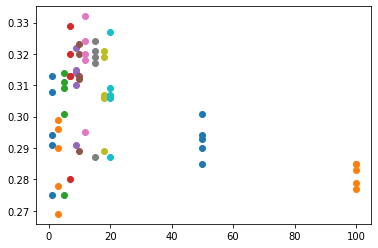

In [104]:
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

We plot the trend line with error bars that correspond to standard deviation.

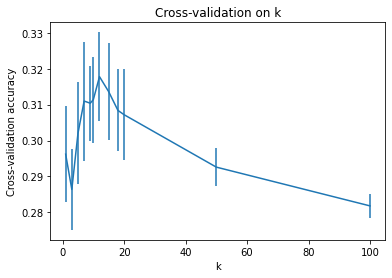

In [106]:
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()